<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/imdb_horror_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defining the questions
Q.1   Analyze which genres have the highest and the lowest average rating

Q.2   Analyze genre combinations which make a movie more succesful in terms of average rating.

# Collecting and cleaning the data

IMDb Dataset:
https://datasets.imdbws.com/

title.basics.tsv.gz - Contains the following information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* titleType (string) – the type/format of the title (e.g. movie, short,
tvseries, tvepisode, video, etc).
* genres (string array) – includes up to three genres associated with
the title.

https://datasets.imdbws.com/title.basics.tsv.gz

title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:
* tconst (string) - alphanumeric unique identifier of the title.
* averageRating – weighted average of all the individual user ratings.
* numVotes - number of votes the title has received.

https://datasets.imdbws.com/title.ratings.tsv.gz

In [13]:
!wget 'https://datasets.imdbws.com/title.basics.tsv.gz'

--2023-02-27 07:11:29--  https://datasets.imdbws.com/title.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.91, 13.249.98.61, 13.249.98.35, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546093 (161M) [binary/octet-stream]
Saving to: ‘title.basics.tsv.gz’

title.basics.tsv.gz 100%[===================>] 160.74M   102MB/s    in 1.6s    

2023-02-27 07:11:31 (102 MB/s) - ‘title.basics.tsv.gz’ saved [168546093/168546093]



"basics" table is over 100 MB, so it can't be download with gdown. You have to mount Google Drive into notebook.

In [21]:
!gzip -df '/content/title.basics.tsv.gz'

In [23]:
!wget 'https://datasets.imdbws.com/title.ratings.tsv.gz'

--2023-02-27 07:12:45--  https://datasets.imdbws.com/title.ratings.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.73, 13.249.98.61, 13.249.98.91, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6445044 (6.1M) [binary/octet-stream]
Saving to: ‘title.ratings.tsv.gz.3’

title.ratings.tsv.g 100%[===================>]   6.15M  30.8MB/s    in 0.2s    

2023-02-27 07:12:46 (30.8 MB/s) - ‘title.ratings.tsv.gz.3’ saved [6445044/6445044]



In [25]:
!gzip -df '/content/title.ratings.tsv.gz'

In [17]:
import pandas as pd
import seaborn as sns

Parse the files.

From basics we keep only movies and relevant fields.

In [18]:
fields = ['tconst', 'titleType', 'primaryTitle',  'startYear', 'genres']
basics = pd.read_table('/content/title.basics.tsv', usecols=fields)[lambda row: row['titleType'] == 'movie']     

In [28]:
basics.head()

,tconst,titleType,primaryTitle,startYear,genres
8,tt0000009,movie,Miss Jerry,1894,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,1905,\N
570,tt0000574,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,1907,Drama


Parse ratings table

In [29]:
ratings = pd.read_table('/content/title.ratings.tsv')

In [30]:
ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1955
1,tt0000002,5.8,263
2,tt0000003,6.5,1788
3,tt0000004,5.6,179
4,tt0000005,6.2,2591


# Process

Merge "basics" table with "ratings" table into one "df" table

In [31]:
df = basics.merge(ratings, on='tconst', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636863 entries, 0 to 636862
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   tconst         636863 non-null  object 
 1   titleType      636863 non-null  object 
 2   primaryTitle   636863 non-null  object 
 3   startYear      636863 non-null  object 
 4   genres         636863 non-null  object 
 5   averageRating  287823 non-null  float64
 6   numVotes       287823 non-null  float64
dtypes: float64(2), object(5)
memory usage: 38.9+ MB


Remove rows without genres or with votes no less than 1000 (from ~635k titles down to ~39k).

In [32]:
min_numVotes = 1000
df = df[(df['genres'] != r'\N') & (df['numVotes'] >= min_numVotes)].copy()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39370 entries, 132 to 636854
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         39370 non-null  object 
 1   titleType      39370 non-null  object 
 2   primaryTitle   39370 non-null  object 
 3   startYear      39370 non-null  object 
 4   genres         39370 non-null  object 
 5   averageRating  39370 non-null  float64
 6   numVotes       39370 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.4+ MB


No we check genres combinations in order to define broader categories.

In [34]:
df.genres.value_counts().head()

Drama                   3078
Comedy                  1913
Comedy,Drama            1790
Drama,Romance           1594
Comedy,Drama,Romance    1502
Name: genres, dtype: int64

Genres is a string of maximum of 3 genres associated with the title.

For our analysis we map broader genre definitions in the following order:

1. Animation
2. Documentary
3. Musical
4. Comedy
5. Horror
6. Action
7. Adventure
8. Thriller
9. Crime
10. Drama
11. Other

[IMDB genre definitions](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG)

In [35]:
#@title Genres processing

# Returns the genre in the order of genres_order
def get_genre(string):
    string_list = string.split(',')
    genres_order = ['Animation', 'Documentary', 'Musical', 'Comedy', 'Horror', 'Action', 'Adventure',
                    'Thriller', 'Crime', 'Drama']
    if len(string_list) == 1:
        if string_list[0] in genres_order:
            return string_list[0]
        else:
            return 'Other'
    for genre in genres_order:
        if genre in string_list:
            return genre
    return 'Other'

In [36]:
df['genre'] = df['genres'].map(lambda genre: get_genre(genre))

In [37]:
df.genre.value_counts(dropna=False)

Comedy         12347
Drama           8038
Action          4789
Horror          4332
Thriller        2713
Documentary     1956
Crime           1795
Animation       1285
Adventure       1004
Musical          668
Other            443
Name: genre, dtype: int64

We check which of genres combinations have NaN in "genre" column. Should be empty table.

In [38]:
df[df['genre'].isna()].groupby('genres')['tconst'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,genres,count


Let's see if our classification makes sense by viewing the most popular titles and their genres/genre.

In [39]:
df[['primaryTitle', 'startYear', 'genres', 'genre', 'averageRating', 'numVotes']].sort_values('numVotes', ascending=False).head(10)

,primaryTitle,startYear,genres,genre,averageRating,numVotes
77477,The Shawshank Redemption,1994,Drama,Drama,9.3,2706353.0
208494,The Dark Knight,2008,"Action,Crime,Drama",Action,9.0,2679814.0
309189,Inception,2010,"Action,Adventure,Sci-Fi",Action,8.8,2377823.0
91307,Fight Club,1999,Drama,Drama,8.8,2150874.0
76649,Forrest Gump,1994,"Drama,Romance",Drama,8.8,2102744.0
77314,Pulp Fiction,1994,"Crime,Drama",Crime,8.9,2077780.0
89185,The Matrix,1999,"Action,Sci-Fi",Action,8.7,1931124.0
82659,The Lord of the Rings: The Fellowship of the Ring,2001,"Action,Adventure,Drama",Action,8.8,1892516.0
50030,The Godfather,1972,"Crime,Drama",Crime,9.2,1879379.0
218359,Interstellar,2014,"Adventure,Drama,Sci-Fi",Adventure,8.6,1864738.0


# Q.1 Analysis
The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate weighted rating:
 
 
\begin{equation}
\text{WR} = \frac{v}{v+m} \times R + \frac{m}{v+m} \times C 
\end{equation}

Where:

$R$ = average for the movie (mean) = (averageRating)

$v$ = number of votes for the movie = (numVotes)

$m$ = minimum votes required to be listed in the Top 250 (currently 25000)

$C$ = the mean vote across the whole report (currently 7.0)

For the Top 250, only votes from regular voters are considered.

Since IMDb doesn't disclose who are regular voters, we can't really know what is the exact criteria.

[Source](https://www.quora.com/What-algorithm-does-IMDB-use-to-decide-the-top-250-movies)

We use this formula, however we calculate mean "averageRating" across whole df and minimum numVotes is 1000.

In [40]:
df['wr'] = ((df['numVotes'] / (df['numVotes'] + min_numVotes)) * df['averageRating']) + ((min_numVotes / (df['numVotes'] + min_numVotes)) * df['averageRating'].mean())

In [41]:
df[['primaryTitle', 'wr']].sort_values('wr', ascending=False).head(10)

,primaryTitle,wr
365438,The Silence of Swastika,9.305986
77477,The Shawshank Redemption,9.298879
50030,The Godfather,9.198439
142663,The Chaos Class,9.130708
450450,CM101MMXI Fundamentals,9.040425
208494,The Dark Knight,8.998980
103943,The Lord of the Rings: The Return of the King,8.998533
75695,Schindler's List,8.998002
52069,The Godfather Part II,8.997871
35976,12 Angry Men,8.996583


Let's see how our top movies by 'wr' compares with IMDB's top 10.

https://www.kaggle.com/datasets/rajugc/imdb-top-250-movies-dataset

https://drive.google.com/file/d/1qxOUIz2ZBLa-bd7Q7aTr-zBKXQKoFPPw/view?usp=sharing

In [42]:
! gdown 1qxOUIz2ZBLa-bd7Q7aTr-zBKXQKoFPPw

Downloading...
From: https://drive.google.com/uc?id=1qxOUIz2ZBLa-bd7Q7aTr-zBKXQKoFPPw
To: /content/IMDB Top 250.zip
100% 52.8k/52.8k [00:00<00:00, 52.5MB/s]


In [43]:
! unzip -o '/content/IMDB Top 250.zip'

Archive:  /content/IMDB Top 250.zip
  inflating: IMDB Top 250 Movies.csv  


In [44]:
imdb_top_250 = pd.read_csv('/content/IMDB Top 250 Movies.csv', usecols=['rank', 'name', 'rating'])
imdb_top_250.head(10)

,rank,name,rating
0,1,The Shawshank Redemption,9.3
1,2,The Godfather,9.2
2,3,The Dark Knight,9.0
3,4,The Godfather Part II,9.0
4,5,12 Angry Men,9.0
5,6,Schindler's List,9.0
6,7,The Lord of the Rings: The Return of the King,9.0
7,8,Pulp Fiction,8.9
8,9,The Lord of the Rings: The Fellowship of the Ring,8.8
9,10,"The Good, the Bad and the Ugly",8.8


We notice that IMDB 250 does not include popular movies in languages other than English.

Now let's see statistics on ratings of movie genres.

In [45]:
df.groupby('genre')['wr'].agg(['count', 'mean', 'min', 'max', 'std']).sort_values(['mean'], ascending=False)

,count,mean,min,max,std
genre,,,,,
Documentary,1956,6.966055,1.660328,9.305986,0.653241
Drama,8038,6.653223,1.070450,9.298879,0.712394
Crime,1795,6.635744,1.859626,9.198439,0.706751
Animation,1285,6.589530,1.705140,8.901424,0.848586
Musical,668,6.492767,2.058175,8.556296,0.808024
Adventure,1004,6.393644,1.978319,8.898707,0.812515
Thriller,2713,6.284722,1.324188,8.903503,0.835469
Comedy,12347,6.208169,1.131169,9.130708,0.862091
Other,443,6.171628,2.618381,8.713398,0.912891


We see that Horror genre has the lowest mean rating.

In [46]:
result = df.groupby('genre')['wr'].agg(['mean']).sort_values(['mean']).copy()
result

,mean
genre,
Horror,5.570737
Action,6.130428
Other,6.171628
Comedy,6.208169
Thriller,6.284722
Adventure,6.393644
Musical,6.492767
Animation,6.589530
Crime,6.635744


# Q.1 Visualize

<AxesSubplot:title={'center':'Genre vs Weighted average rating'}, ylabel='genre'>

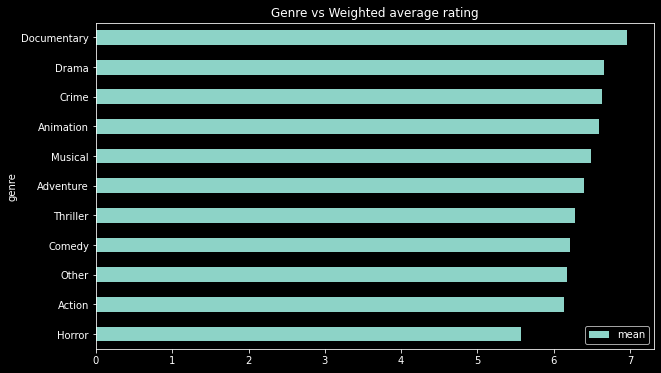

In [47]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
figsize = (10, 6)

result.plot(kind='barh', title='Genre vs Weighted average rating', figsize=figsize)

<AxesSubplot:title={'center':'Scatter plot (Weighted average Rating vs Genre)'}, xlabel='genre', ylabel='wr'>

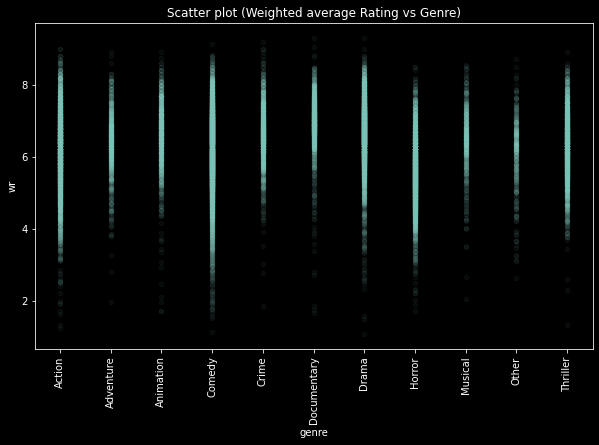

In [48]:
df.sort_values('genre').reset_index().plot(x='genre', y='wr', kind='scatter', alpha=0.05, rot=90,
                                           title='Scatter plot (Weighted average Rating vs Genre)', figsize=figsize)

# Q.2 Analysis

In [49]:
# Splits string of genres into a list of secondary and third genres.
# Or just the secondary if there are only 2 genres in the string.
# If there is only 1 genre in the string, then return empty list.
def split_series(series, genre):
  series_list = series.str.split(',')[0]
  if len(series_list) == 1:
    return ['empty', 'empty']
  elif len(series_list) == 2:
    series_list.remove(genre)
    return series_list + ['empty']
  else :
    series_list.remove(genre)
    return series_list

We select all movies with 'Horror' in "genres" string and split the genres into columns "genre_2" and "genre_3".

In [50]:
test_genre = 'Horror'
t = df[df['genres'].str.contains(test_genre)].copy()
t[['genre_2', 'genre_3']] = t[['genres']].apply(split_series, axis=1, result_type='expand', genre=test_genre)

We keep only those combination of genres with count > 10.

In [51]:
t = t[t.groupby('genres').genres.transform('count') >= 10].copy()

Prepare a pivot table for a heatmap

In [52]:
result_2 = t.pivot_table(index='genre_2',columns=['genre_3'],values='wr',aggfunc=['mean'])
result_2

mean                                                    \
genre_3     Adventure    Comedy     Crime     Drama   Fantasy     Music   
genre_2                                                                   
Action        5.19938  5.558055  5.809944  5.478729  5.544629       NaN   
Adventure         NaN  5.359767       NaN  5.637648  5.523907       NaN   
Comedy            NaN       NaN  6.073245  5.896407  5.658542  5.714528   
Crime             NaN       NaN       NaN  5.970885       NaN       NaN   
Documentary       NaN       NaN       NaN       NaN       NaN       NaN   
Drama             NaN       NaN       NaN       NaN  6.069809       NaN   
Fantasy           NaN       NaN       NaN       NaN       NaN       NaN   
Mystery           NaN       NaN       NaN       NaN       NaN       NaN   
Romance           NaN       NaN       NaN       NaN       NaN       NaN   
Sci-Fi            NaN       NaN       NaN       NaN       NaN       NaN   
Thriller          NaN       NaN       NaN       NaN       NaN       NaN   
empty             NaN       NaN       NaN       NaN       NaN       NaN   

                                                                        
genre_3      Musical   Mystery   Romance    Sci-Fi  Thriller     empty  
genre_2                                                                 
Action           NaN  5.326728       NaN  5.300008  5.231271  5.262183  
Adventure        NaN  5.780473       NaN  5.387845  5.347200  5.654662  
Comedy       5.95662  5.807410  5.902030  5.438698  5.494468  5.499076  
Crime            NaN  5.923293       NaN  5.603838  5.560705  5.895074  
Documentary      NaN       NaN       NaN       NaN       NaN  6.164494  
Drama            NaN  5.881533  5.962605  5.955595  5.709399  6.054633  
Fantasy          NaN  5.697485       NaN  5.637928  5.434070  5.710064  
Mystery          NaN       NaN  5.771648  5.629328  5.634283  5.711162  
Romance          NaN       NaN       NaN       NaN  5.250994       NaN  
Sci-Fi           NaN       NaN       NaN       NaN  5.376402  5.363409  
Thriller         NaN       NaN       NaN       NaN       NaN  5.354069  
empty            NaN       NaN       NaN       NaN       NaN  5.353544

# Q.2 Vizualize

<AxesSubplot:xlabel='None-genre_3', ylabel='genre_2'>

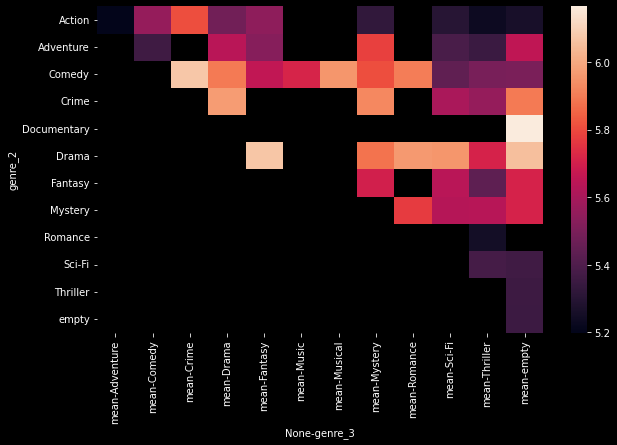

In [53]:
fig, ax = plt.subplots(figsize=figsize)  
sns.heatmap(result_2)

We conclude that for the Horror combinations with the Comedy and Drama are the most successful in terms of rating. Because Documentary has the highest mean rating overall, the Horror documentaries also show good result.

# Play

In [54]:
#@title Here we can try all sorts of weird genres combinations to find a movie for the evening watch
# 'Fantasy,Horror,Romance'
df[df['genres'] == 'Fantasy,Horror,Romance'].sort_values(['startYear'], ascending=False)

,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes,genre,wr
252989,tt11116374,movie,Don't Kill Me,2021,"Fantasy,Horror,Romance",4.3,2092.0,Horror,4.935509
63569,tt0088851,movie,The Bride,1985,"Fantasy,Horror,Romance",5.4,3305.0,Horror,5.600928
49748,tt0068284,movie,Blacula,1972,"Fantasy,Horror,Romance",5.7,7173.0,Horror,5.769129
